In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
sns.set_style('whitegrid')

#### Train Data

In [4]:
df_train = pd.read_csv(r'G:\Project\NewYorkTaxiFare\data\train.csv', nrows=2_000_00, parse_dates=["pickup_datetime"])

#### Exploratory Data Analysis

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
key                  200000 non-null object
fare_amount          200000 non-null float64
pickup_datetime      200000 non-null datetime64[ns]
pickup_longitude     200000 non-null float64
pickup_latitude      200000 non-null float64
dropoff_longitude    199999 non-null float64
dropoff_latitude     199999 non-null float64
passenger_count      200000 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 12.2+ MB


In [6]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [7]:
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

### Data Pre-Processing

#### Minimum Fare-Amount is Negative, so we havce to remove these observations

In [8]:
df_train = df_train[df_train["fare_amount"] >= 0]

In [9]:
len(df_train)

199987

#### Histogram of fare amount

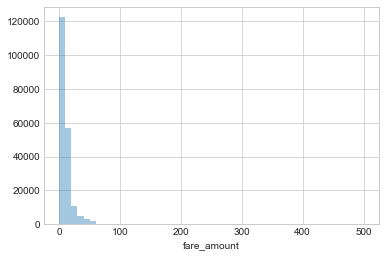

In [10]:
sns.distplot(df_train["fare_amount"], kde=False);

** Notice - smalll spkie between \$40 and \$60 **

### Remove Missing Data

In [11]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [12]:
df_train = df_train.dropna(how='any', axis='rows')

In [13]:
len(df_train)

199986

### Test Data

In [14]:
df_test = pd.read_csv(r'G:\Project\NewYorkTaxiFare\data\test.csv')

In [15]:
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [16]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


#### NewYork City coordinates are https://www.travelmath.com/cities/New+York,+NY

In [17]:
latitude =  40.7141667
longitude =  -74.0063889

#### Here, we will try to define bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from test.csv. 
This will help us to make sure to train a model for the full pickup/dropoff co-ordinate range for the test set.

#### Minimum and Maximum Longitude Test set

In [18]:
print(min(df_test["pickup_longitude"].min(), df_test["dropoff_longitude"].min()))

-74.263242


In [19]:
print(max(df_test["pickup_longitude"].max(), df_test["dropoff_longitude"].max()))

-72.986532


#### Minimum and Maximum Latutude Test Set

In [20]:
print(min(df_test["pickup_latitude"].min(), df_test["dropoff_latitude"].min()))

40.568973


In [21]:
print(max(df_test["pickup_latitude"].max(), df_test["dropoff_latitude"].max()))

41.709555


### Function for selecting the bounding box

In [22]:
def select_within_boundingbox(df, BB):
    return ((df["pickup_longitude"] >= BB[0]) & (df["pickup_longitude"] <= BB[1]) & 
            (df["pickup_latitude"] >= BB[2]) & (df["pickup_latitude"] <= BB[3]) &
            (df["dropoff_longitude"] >= BB[0]) & (df["dropoff_longitude"] <= BB[1]) &
            (df["dropoff_latitude"] >= BB[2]) & (df["dropoff_latitude"] <= BB[3]))

#### Load Image of NYC Map for Visualization

In [23]:
BB = (-74.3, -73.0, 40.6, 41.7)

In [24]:
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

In [25]:
df_train = df_train[select_within_boundingbox(df_train, BB)]

In [26]:
print("New size {}".format(len(df_train)))

New size 195612


#### Function will be used for plotting data on NYC Map

In [27]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1,2,figsize=(16, 10))
    axs[0].scatter(df["pickup_longitude"], df["pickup_latitude"], alpha = alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup Locations')
    axs[0].imshow(nyc_map, extent=BB)
    
    axs[1].scatter(df["dropoff_longitude"], df["dropoff_latitude"] , alpha = alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff Locations')
    axs[1].imshow(nyc_map, extent=BB)

#### Plotting Training Data on map

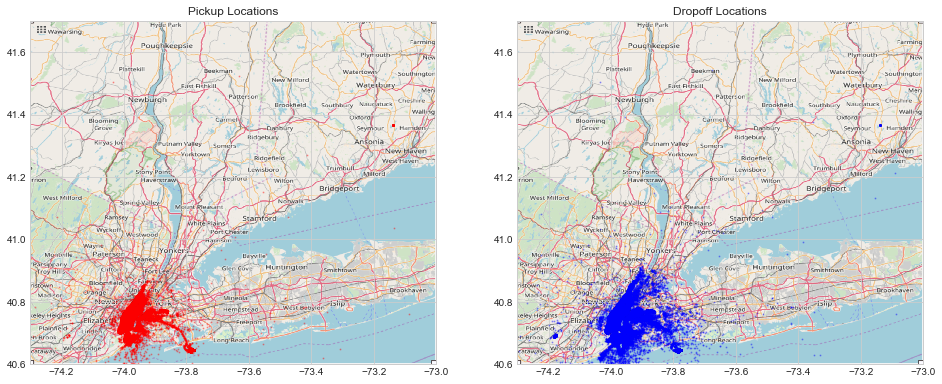

In [28]:
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

#### Plotting testing Data on Map

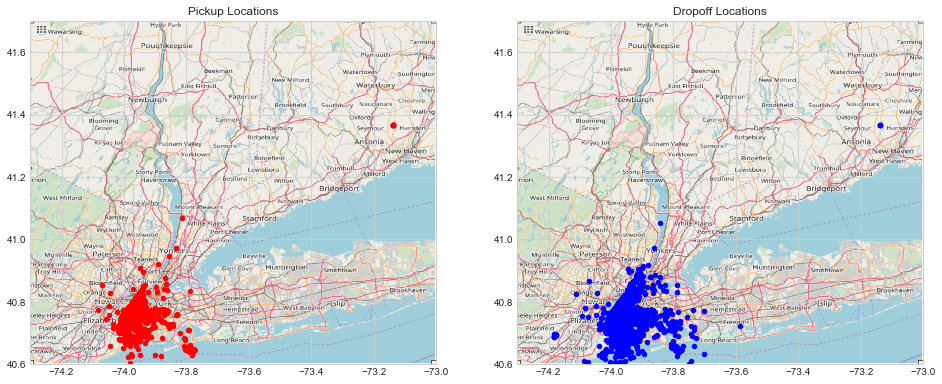

In [29]:
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)

In [30]:
# add time information
df_train['year'] = df_train["pickup_datetime"].apply(lambda t: t.year)
df_train['weekday'] = df_train["pickup_datetime"].apply(lambda t: t.weekday())
df_train['hour'] = df_train["pickup_datetime"].apply(lambda t: t.hour)

### Distance and Time Visualization

1. **The longer the distance between pickup and dropoff locations, the higher the fare.**
2. **Some trips, like to/from an airport are fixed fee.**
3. **Fare at night is different from the day time.**

### Formula to be used for calculating the distance between latitude and longitude

In [31]:
def distance(lat1, lon1, lat2, lon2):
  p = 0.017453292519943295 # Pi/180
  a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p))/2
  return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

#### The longer the distance between pickup and dropoff location, higher the fare. Adding new column to dataframe with distance in miles

In [32]:
df_train["distance_miles"] = distance(df_train["pickup_latitude"], df_train["pickup_longitude"], 
                                      df_train["dropoff_latitude"], df_train["dropoff_longitude"])

In [33]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,0,17,0.640487
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,16,5.250670


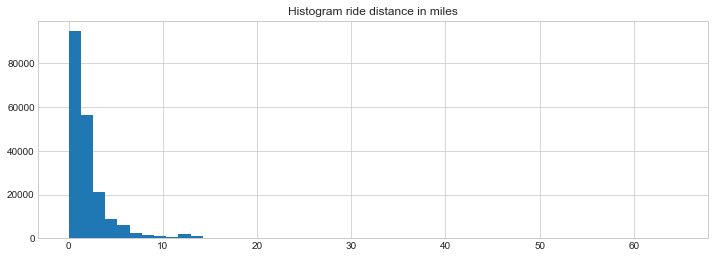

In [34]:
df_train["distance_miles"].hist(bins=50, figsize=(12,4))
plt.title("Histogram ride distance in miles");

In [35]:
df_train["distance_miles"].describe()

count    195612.000000
mean          2.063410
std           2.352008
min           0.000000
25%           0.780419
50%           1.337858
75%           2.423327
max          64.644331
Name: distance_miles, dtype: float64

#### It seems most rides are just short rides, with a small peak at ~13 miles. This peak could be due to airport drives. 

In [36]:
df_train.groupby('passenger_count')['distance_miles','fare_amount'].mean()

,distance_miles,fare_amount
passenger_count,,
0,1.836291,9.080659
1,2.035126,11.169553
2,2.174035,11.786048
3,2.070869,11.332867
4,2.126675,11.680824
5,2.066121,11.172870
6,2.168814,12.354238


#### Scatter Plot distance vs Fare

Text(0.5,1,'Zoom in on distance < 15 mile and fare < $100')

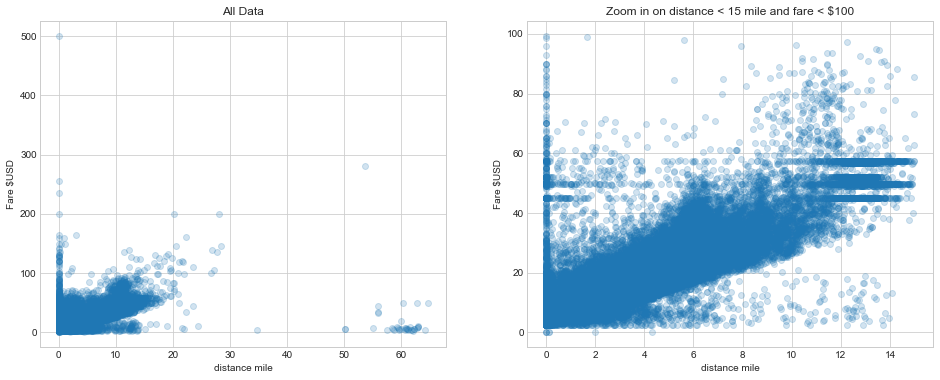

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_train["distance_miles"], df_train["fare_amount"], alpha=0.2)
axs[0].set_xlabel("distance mile")
axs[0].set_ylabel("Fare $USD")
axs[0].set_title("All Data")

# Zoom-in some part of the data
idx = ((df_train['distance_miles'] < 15) & (df_train["fare_amount"] < 100))
axs[1].scatter(df_train[idx]["distance_miles"], df_train[idx]["fare_amount"], alpha=0.2)
axs[1].set_xlabel("distance mile")
axs[1].set_ylabel("Fare $USD")
axs[1].set_title("Zoom in on distance < 15 mile and fare < $100")

**Few Obervations -**
1. There are trips with zero distance but with a non-zero fare. Could this be trips from and to the same location? Predicting these fares will be difficult as there is likely not sufficient information in the dataset.
2. There are some trips with >50 miles travel distance but low fare. Perhaps these are discounted trips? Or the previously mentioned hotspot near Seymour (see density plots above)?
3. The horizontal lines in the right plot might indicate again the fixed fare trips to/from JFK airport.
Overall there seems to be a (linear) relation between distance and fare with an average rate of +/- 100/20 = 5 $USD/mile

In [38]:
# remove datapoints with distance <0.05 miles
idx = (df_train["distance_miles"] >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 195612
New size: 192447


#### JKF airport coordinates, see https://www.travelmath.com/airport/JFK

In [39]:
jfk = (-73.7822222222,40.6441666667)
nyc = (-74.0063889, 40.7141667)

In [40]:
def plot_location_fare(loc, name, range=1.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    idx = (distance(df_train["pickup_latitude"], df_train["pickup_longitude"], loc[1], loc[0]) < range)
    df_train[idx]["fare_amount"].hist(bins = 100, ax=axs[0])
    axs[0].set_xlabel("Fare $USD")
    axs[0].set_title("Histogram pickup location within {} miles of {}".format(range, name))
    
    idx = (distance(df_train["dropoff_latitude"], df_train["dropoff_longitude"], loc[1], loc[0]) < range)
    df_train[idx]["fare_amount"].hist(bins=100, ax=axs[1])
    axs[1].set_xlabel("Fare $USD")
    axs[1].set_title("Histogram dropoff location within {} miles of {}".format(range, name))

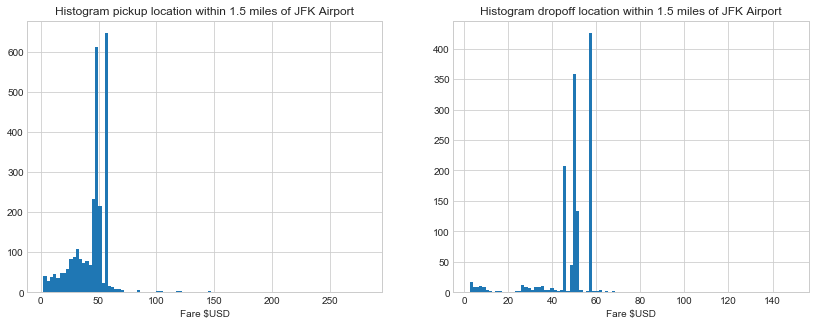

In [41]:
plot_location_fare(jfk, 'JFK Airport')

In [42]:
#Other Airports
ewr = (-74.175, 40.69) #Newark Liberty International Airport https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) #Laguardia Airport, https://www.travelmath.com/airport/LGA

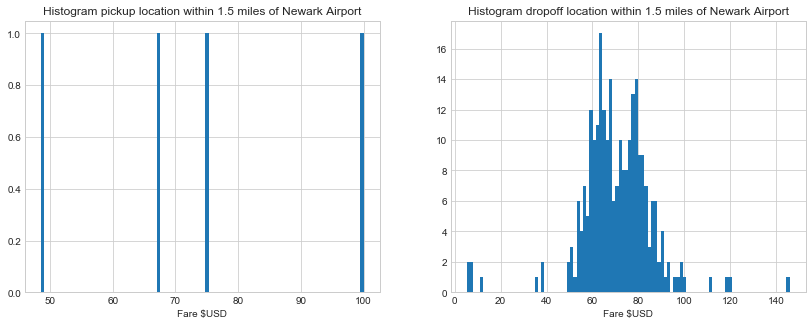

In [43]:
plot_location_fare(ewr, 'Newark Airport')

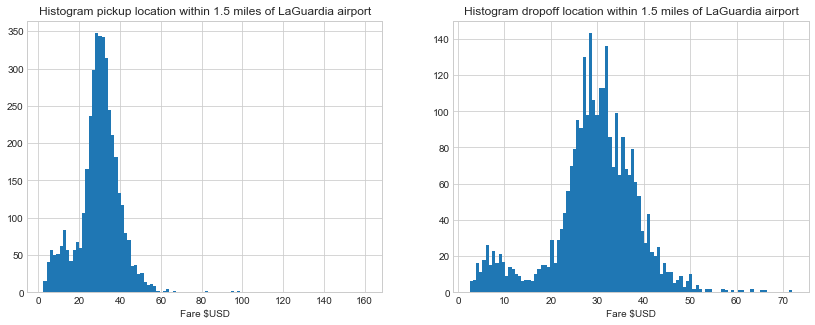

In [44]:
plot_location_fare(lgr, 'LaGuardia airport')

#### Fare at night is different from the day time

In [45]:
df_train["fare_per_mile"] = df_train["fare_amount"] / df_train["distance_miles"]

In [46]:
df_train["fare_per_mile"].describe()

count    192447.000000
mean          7.404693
std          15.918010
min           0.000000
25%           4.771146
50%           6.137379
75%           8.072801
max        3812.571628
Name: fare_per_mile, dtype: float64

Text(0,0.5,'fare per distance in mile')

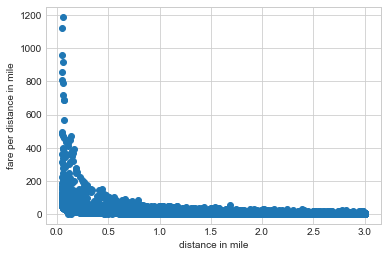

In [47]:
idx = (df_train["distance_miles"] < 3) & (df_train["fare_amount"] < 100)
plt.scatter(df_train[idx]["distance_miles"], df_train[idx]["fare_per_mile"])
plt.xlabel("distance in mile")
plt.ylabel("fare per distance in mile")

### Pivot Table

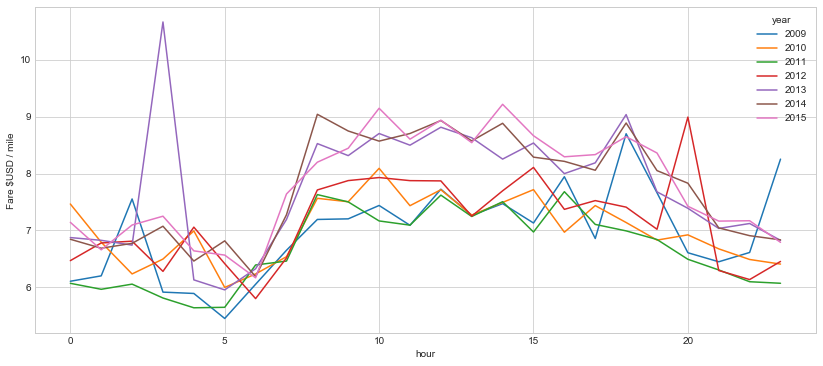

In [48]:
df_train.pivot_table("fare_per_mile", index="hour", columns="year").plot(figsize=(14,6))
plt.ylabel("Fare $USD / mile");

### Relevance of direction for calculation of fare amount

In [49]:
df_train["delta_lon"] = df_train["pickup_longitude"] - df_train["dropoff_longitude"]
df_train["delta_lat"] = df_train["pickup_latitude"] - df_train["dropoff_latitude"]

#### Select trips in Manhattan

In [50]:
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df_train, BB_manhattan)

Text(0.5,1,'log1p(fare_amount)')

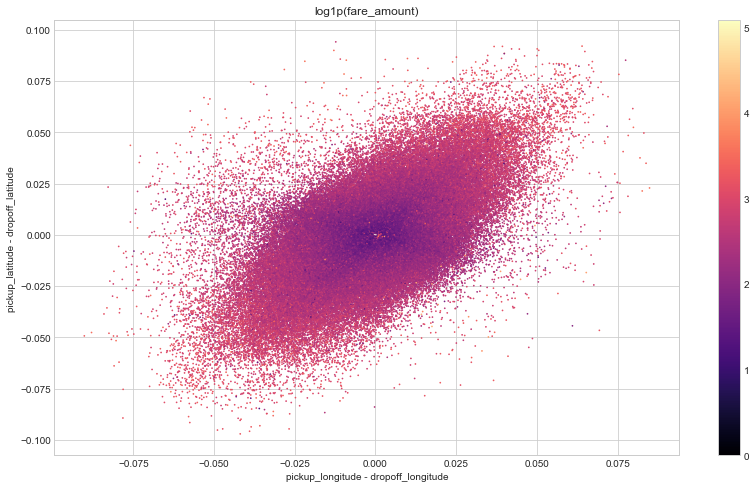

In [51]:
plt.figure(figsize=(14,8))
plt.scatter(df_train[idx_manhattan]["delta_lon"], df_train[idx_manhattan]["delta_lat"], s=0.5, alpha=1.0,
            c=np.log1p(df_train[idx_manhattan]["fare_amount"]), cmap="magma")
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latitude')
plt.title('log1p(fare_amount)')

#### Looks like direction of the trip seems to matter. Direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees

In [52]:
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

In [53]:
df_train['direction'] = calculate_direction(df_train.delta_lon, df_train.delta_lat)

Text(0.5,1,'Histogram direction (Manhattan)')

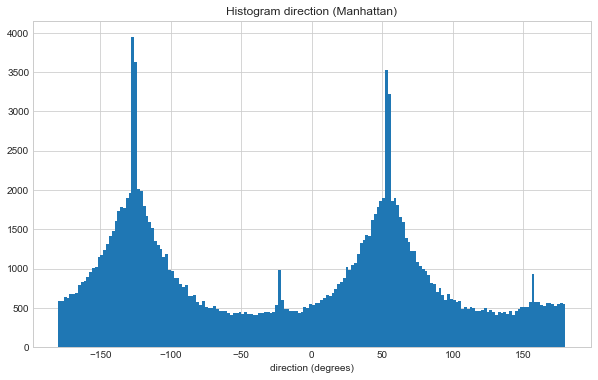

In [54]:
# plot histogram of directions
plt.figure(figsize=(10,6))
df_train[idx_manhattan].direction.hist(bins=180)
plt.xlabel('direction (degrees)')
plt.title('Histogram direction (Manhattan)')

#### Fare varies with pickup location

In [55]:
# add new column to dataframe with distance in mile
df_train['distance_to_center'] = distance(nyc[1], nyc[0], df_train["pickup_latitude"], df_train["pickup_longitude"])

In [56]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,fare_per_mile,delta_lon,delta_lat,direction,distance_to_center
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,0,17,0.640487,7.025903,-0.002701,0.009041,106.633523,8.502079
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,16,5.250670,3.218637,-0.036780,-0.070701,-117.484306,0.543185
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,3,0,0.863411,6.601723,0.008504,0.010708,51.544361,3.482099
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,5,4,1.739386,4.426850,0.004437,-0.024949,-79.915791,1.654108
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,1,7,1.242218,4.266560,-0.011440,-0.015754,-125.985832,4.225834


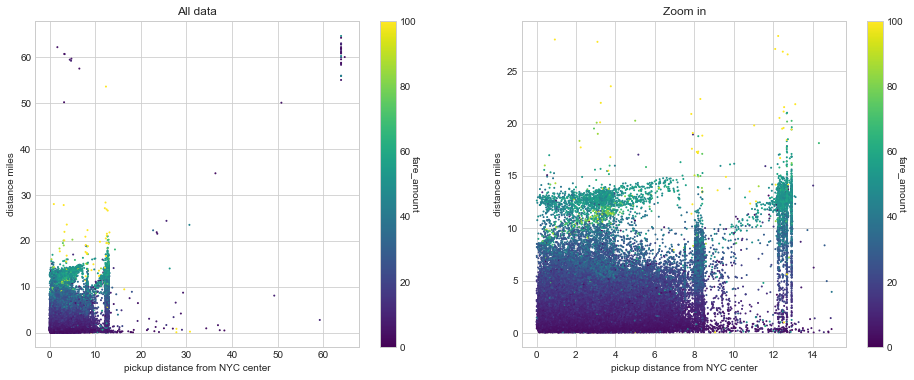

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train["distance_to_center"], df_train["distance_miles"], c=np.clip(df_train["fare_amount"], 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)

axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')

cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)


idx = (df_train["distance_to_center"] < 15) & (df_train["distance_miles"] < 35)
im = axs[1].scatter(df_train[idx]["distance_to_center"], df_train[idx]["distance_miles"], 
                     c=np.clip(df_train[idx]["fare_amount"], 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

#### There is a lot of 'green' dots, which is about \$50 to \$60 fare amount near 13 miles distance of NYC center of distrance of trip. This could be due to trips from/to JFK airport

### Baseline Model and Submission

In [58]:
# add new column to dataframe with distance in km
df_test['distance_miles'] = distance(df_test["pickup_latitude"], df_test["pickup_longitude"], 
                                     df_test["dropoff_latitude"], df_test["dropoff_longitude"])
df_test['distance_to_center'] = distance(nyc[1], nyc[0], df_test["dropoff_latitude"], df_test["dropoff_longitude"])
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
df_test['year'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)

In [59]:
# define dataset
# select points 15 miles near NYC center and remove zero passenger datapoints
idx = (df_train["distance_to_center"] < 15) & (df_train["passenger_count"] != 0)

features = ['year', 'hour', 'distance_miles', 'passenger_count']

X = df_train[idx][features].values
y = df_train[idx]['fare_amount'].values

In [60]:
print(X.shape, y.shape)

(191672, 4) (191672,)


In [61]:
# define some handy analysis support function
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [62]:
# create training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

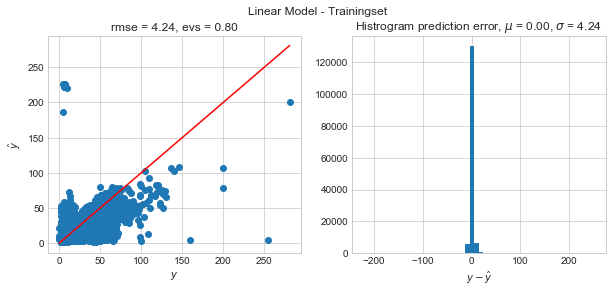

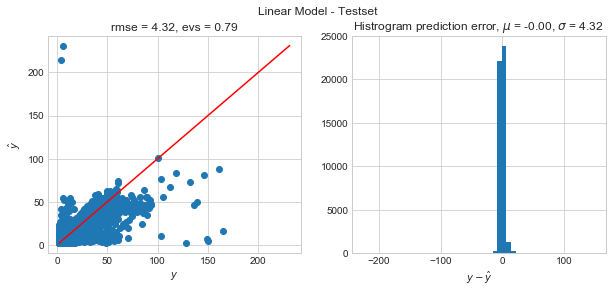

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))

model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)

plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

#### Generate Kaggle Submission

In [64]:
# define dataset
XTEST = df_test[features].values

In [65]:
y_pred_final = model_lin.predict(XTEST)

submission = pd.DataFrame(
    {
        'key': df_test["key"], 
        'fare_amount': y_pred_final
    },
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

In [66]:
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.555572
1,2015-01-27 13:08:24.0000003,10.789395
2,2011-10-08 11:53:44.0000002,4.543063
3,2012-12-01 21:12:12.0000002,8.260033
4,2012-12-01 21:12:12.0000003,16.107165
